# CLUSTERING 1

In [74]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    return np.concatenate([years_scaled, months_scaled,
                           day_sin[:, None], day_cos[:, None],
                           hour_sin[:, None], hour_cos[:, None]], axis=1)

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")
    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in cluster_articles])
    date_feats = process_date_features(cluster_articles)
    indices = [a['bert_idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    if len(X) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough samples")
        return

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    if len(X_train) < 2:
        print(f"⚠️ Skipping cluster {cluster_id} - not enough after split")
        return

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=min(64, len(train_ds)), shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()

    best_mae = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(50):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb, t, st, d).squeeze(), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                pred = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(pred.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:02d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 15:
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")

# --- 7. Main ---
if __name__ == "__main__":
    import shutil
    shutil.rmtree("cluster_models", ignore_errors=True)
    os.makedirs("cluster_models", exist_ok=True)

    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    for i, a in enumerate(train_articles):
        a["bert_idx"] = i
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    for a in val_articles:
        dt = pd.to_datetime(a["date"])
        a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour

    topics = [extract_topics_from_url(a['url'])[0] for a in train_articles]
    subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train_articles]
    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    umap_model = umap.UMAP(n_components=50, random_state=42).fit(bert_train)
    projected_train = umap_model.transform(bert_train)
    kmeans = KMeans(n_clusters=60, random_state=42).fit(projected_train)
    centroids = kmeans.cluster_centers_
    cluster_labels = kmeans.predict(projected_train)
    for i, a in enumerate(train_articles): a["cluster"] = int(cluster_labels[i])

    val_start = min(pd.to_datetime(a["date"]) for a in val_articles)
    year_cutoff = datetime(val_start.year - 2, 1, 1)
    train_recent = [a for a in train_articles if pd.to_datetime(a["date"]) >= year_cutoff]
    for i, a in enumerate(train_recent):
        a["bert_idx"] = i

    for cluster_id in range(60):
        cluster_articles = [a for a in train_recent if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(cluster_id, cluster_articles, bert_train, topic_encoder, subtopic_encoder, "cluster_models")

    print("✅ Done.")

        # Predict on validation set using trained cluster models
    def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
        preds = np.zeros(len(articles))

        for i, a in enumerate(articles):
            dt = pd.to_datetime(a["date"])
            a["year"], a["month"], a["day_of_week"], a["hour"] = dt.year, dt.month, dt.weekday(), dt.hour
            a["bert_idx"] = i  # make sure index is recomputed

        topics = [extract_topics_from_url(a['url'])[0] for a in articles]
        subtopics = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in articles]
        topic_ids = topic_encoder.transform([t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics])
        subtopic_ids = subtopic_encoder.transform([s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics])
        date_feats = process_date_features(articles)

        projected = umap_model.transform(bert_vectors)
        cluster_ids = np.argmin(np.linalg.norm(projected[:, None] - centroids[None], axis=2), axis=1)

        for cluster_id in range(centroids.shape[0]):
            idxs = np.where(cluster_ids == cluster_id)[0]
            if len(idxs) == 0:
                continue

            X = bert_vectors[idxs]
            t = topic_ids[idxs]
            st = subtopic_ids[idxs]
            d = date_feats[idxs]

            dataset = NewsDataset(X, t, st, d)
            dataloader = DataLoader(dataset, batch_size=64)

            model_path = os.path.join(model_dir, f"cluster_{cluster_id}_model.pt")
            if not os.path.exists(model_path):
                print(f"⚠️ Model for cluster {cluster_id} not found. Skipping.")
                continue

            model = MLPWithEmbeddings(
                input_dim=X.shape[1],
                num_topics=len(topic_encoder.classes_),
                num_subtopics=len(subtopic_encoder.classes_)
            )
            model.load_state_dict(torch.load(model_path, map_location="cpu"))
            model.to(DEVICE)
            model.eval()

            cluster_preds = []
            with torch.no_grad():
                for xb, t, st, d in dataloader:
                    xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                    out = model(xb, t, st, d).squeeze()
                    cluster_preds.append(torch.expm1(out.cpu()).numpy().reshape(-1))

            preds[idxs] = np.concatenate(cluster_preds)

        return np.clip(preds, 0, None)

    preds_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    np.savetxt("cluster_predictions/predictions_val.txt", preds_val, fmt="%.2f")
    print("📄 Saved predictions_val.txt")



Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧠 Training cluster 0 with 1151 articles
Epoch 01 - Cluster 0 - Val MAE: 20.09
Epoch 02 - Cluster 0 - Val MAE: 20.10
Epoch 03 - Cluster 0 - Val MAE: 18.90
Epoch 04 - Cluster 0 - Val MAE: 20.94
Epoch 05 - Cluster 0 - Val MAE: 19.73
Epoch 06 - Cluster 0 - Val MAE: 19.63
Epoch 07 - Cluster 0 - Val MAE: 20.23
Epoch 08 - Cluster 0 - Val MAE: 19.09
Epoch 09 - Cluster 0 - Val MAE: 19.57
Epoch 10 - Cluster 0 - Val MAE: 19.33
Epoch 11 - Cluster 0 - Val MAE: 20.48
Epoch 12 - Cluster 0 - Val MAE: 19.80
Epoch 13 - Cluster 0 - Val MAE: 19.62
Epoch 14 - Cluster 0 - Val MAE: 19.42
Epoch 15 - Cluster 0 - Val MAE: 20.67
Epoch 16 - Cluster 0 - Val MAE: 19.46
Epoch 17 - Cluster 0 - Val MAE: 20.62
Epoch 18 - Cluster 0 - Val MAE: 19.69
✅ Saved model for cluster 0 (Val MAE: 18.90)

🧠 Training cluster 1 with 697 articles
Epoch 01 - Cluster 1 - Val MAE: 21.60
Epoch 02 - Cluster 1 - Val MAE: 19.05
Epoch 03 - Cluster 1 - Val MAE: 20.37
Epoch 04 - Cluster 1 - Val MAE: 19.34
Epoch 05 - Cluster 1 - Val MAE: 16.92


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 01 - Cluster 16 - Val MAE: 51.86
Epoch 02 - Cluster 16 - Val MAE: 26.25
Epoch 03 - Cluster 16 - Val MAE: 25.14
Epoch 04 - Cluster 16 - Val MAE: 25.12
Epoch 05 - Cluster 16 - Val MAE: 24.83
Epoch 06 - Cluster 16 - Val MAE: 48.03
Epoch 07 - Cluster 16 - Val MAE: 26.78


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 08 - Cluster 16 - Val MAE: 25.47
Epoch 09 - Cluster 16 - Val MAE: 24.92
Epoch 10 - Cluster 16 - Val MAE: 24.80
Epoch 11 - Cluster 16 - Val MAE: 27.14
Epoch 12 - Cluster 16 - Val MAE: 26.58
Epoch 13 - Cluster 16 - Val MAE: 25.85
Epoch 14 - Cluster 16 - Val MAE: 24.73


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 15 - Cluster 16 - Val MAE: 24.93
Epoch 16 - Cluster 16 - Val MAE: 24.81
Epoch 17 - Cluster 16 - Val MAE: 24.98
Epoch 18 - Cluster 16 - Val MAE: 26.23
Epoch 19 - Cluster 16 - Val MAE: 24.32
Epoch 20 - Cluster 16 - Val MAE: 28.06
Epoch 21 - Cluster 16 - Val MAE: 25.77


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 22 - Cluster 16 - Val MAE: 25.44
Epoch 23 - Cluster 16 - Val MAE: 26.68
Epoch 24 - Cluster 16 - Val MAE: 24.64
Epoch 25 - Cluster 16 - Val MAE: 25.17
Epoch 26 - Cluster 16 - Val MAE: 24.78
Epoch 27 - Cluster 16 - Val MAE: 24.71
Epoch 28 - Cluster 16 - Val MAE: 25.21


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:1102: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

Epoch 29 - Cluster 16 - Val MAE: 25.41
Epoch 30 - Cluster 16 - Val MAE: 24.55
Epoch 31 - Cluster 16 - Val MAE: 25.24
Epoch 32 - Cluster 16 - Val MAE: 24.73
Epoch 33 - Cluster 16 - Val MAE: 25.02
Epoch 34 - Cluster 16 - Val MAE: 24.70
✅ Saved model for cluster 16 (Val MAE: 24.32)

🧠 Training cluster 17 with 267 articles
Epoch 01 - Cluster 17 - Val MAE: 34.48
Epoch 02 - Cluster 17 - Val MAE: 34.87
Epoch 03 - Cluster 17 - Val MAE: 34.03
Epoch 04 - Cluster 17 - Val MAE: 34.86
Epoch 05 - Cluster 17 - Val MAE: 35.55
Epoch 06 - Cluster 17 - Val MAE: 34.79
Epoch 07 - Cluster 17 - Val MAE: 33.47
Epoch 08 - Cluster 17 - Val MAE: 33.30
Epoch 09 - Cluster 17 - Val MAE: 33.48
Epoch 10 - Cluster 17 - Val MAE: 33.32
Epoch 11 - Cluster 17 - Val MAE: 33.37
Epoch 12 - Cluster 17 - Val MAE: 33.97
Epoch 13 - Cluster 17 - Val MAE: 33.03
Epoch 14 - Cluster 17 - Val MAE: 33.12
Epoch 15 - Cluster 17 - Val MAE: 33.50
Epoch 16 - Cluster 17 - Val MAE: 34.42
Epoch 17 - Cluster 17 - Val MAE: 34.55
Epoch 18 - Clust

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📄 Saved predictions_val.txt


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: num must be an integer with 1 <= num <= 15, not 16

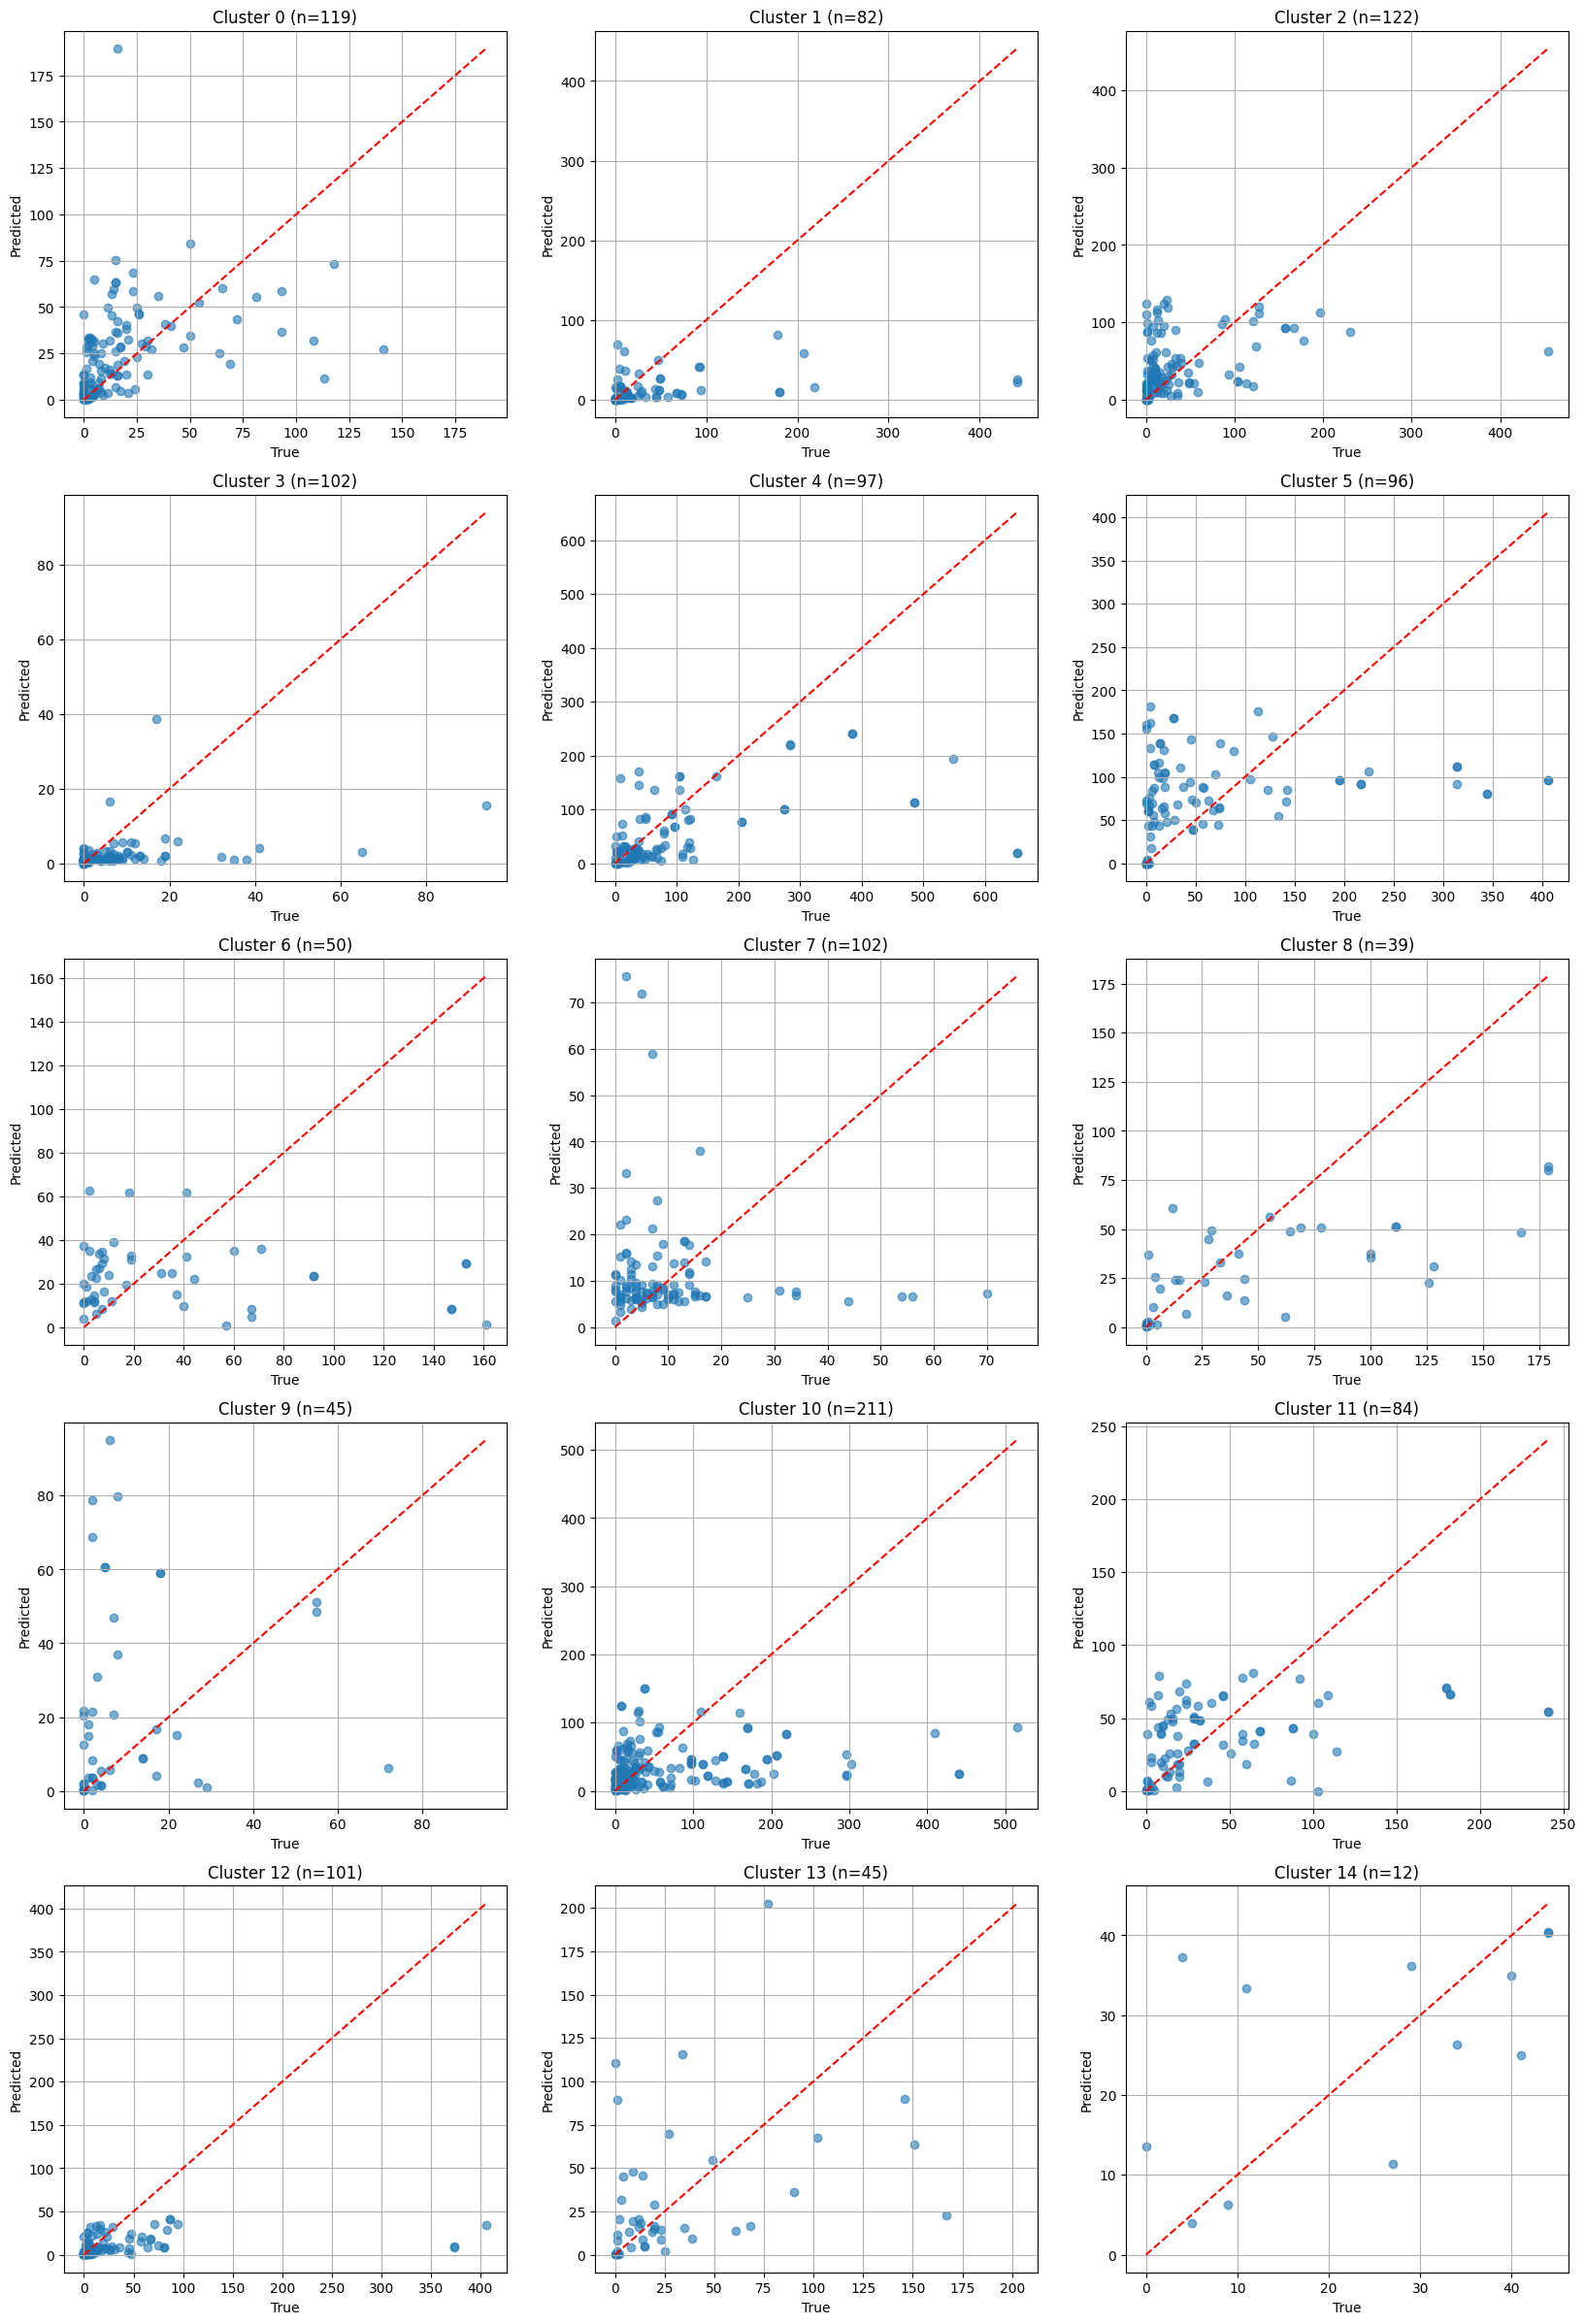

In [71]:
import matplotlib.pyplot as plt

# Group predictions and true values by cluster
projected_val = umap_model.transform(bert_val)
cluster_ids = np.argmin(np.linalg.norm(projected_val[:, None] - centroids[None], axis=2), axis=1)
true_vals = np.array([a['n_comments'] for a in val_articles])

# Plot predictions vs true values per cluster
plt.figure(figsize=(20, 30))
for cluster_id in range(centroids.shape[0]):
    idxs = np.where(cluster_ids == cluster_id)[0]
    if len(idxs) == 0:
        continue
    plt.subplot(5, 3, cluster_id + 1)
    plt.scatter(true_vals[idxs], preds_val[idxs], alpha=0.6)
    plt.plot([0, max(true_vals[idxs].max(), preds_val[idxs].max())],
             [0, max(true_vals[idxs].max(), preds_val[idxs].max())],
             color='red', linestyle='--')
    plt.title(f"Cluster {cluster_id} (n={len(idxs)})")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)

plt.tight_layout()
plt.savefig("cluster_predictions/validation_scatter_per_cluster.png")
plt.show()


# VISUALIZATION OF CLUSTERS VS VAL

In [ ]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import joblib

# === 1. Load models ===
umap_model = joblib.load("umap_model.pkl")
centroids = np.load("cluster_centroids.npy")

# === 2. Load embeddings ===
emb_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
emb_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

# === 3. Project with UMAP ===
proj_train = umap_model.transform(emb_train)
proj_val = umap_model.transform(emb_val)

# === 4. Assign clusters ===
def assign_clusters(projected, centroids):
    dists = np.linalg.norm(projected[:, None] - centroids[None], axis=2)
    return np.argmin(dists, axis=1)

train_labels = assign_clusters(proj_train, centroids)
val_labels = assign_clusters(proj_val, centroids)

# === 5. Load articles ===
with open("rtvslo_train.json", "r", encoding="utf-8") as f:
    articles_train = json.load(f)
with open("rtvslo_validation.json", "r", encoding="utf-8") as f:
    articles_val = json.load(f)

assert len(articles_train) == len(train_labels)
assert len(articles_val) == len(val_labels)

# === 6. Group by cluster ===
train_clusters = defaultdict(list)
val_clusters = defaultdict(list)

for article, label in zip(articles_train, train_labels):
    train_clusters[label].append(article)

for article, label in zip(articles_val, val_labels):
    val_clusters[label].append(article)

# === 7. Cutoff date = start of year of oldest val article
min_val_date = min(datetime.fromisoformat(a["date"]) for a in articles_val)
train_cutoff_date = datetime(min_val_date.year, 1, 1)

# === 8. Plot side-by-side per cluster
for cluster_id in sorted(set(train_clusters.keys()) | set(val_clusters.keys())):
    train_articles = [
        a for a in train_clusters.get(cluster_id, [])
        if datetime.fromisoformat(a["date"]) >= train_cutoff_date
    ]
    val_articles = val_clusters.get(cluster_id, [])

    train_dates = [datetime.fromisoformat(a["date"]) for a in train_articles]
    train_comments = [a["n_comments"] for a in train_articles]

    val_dates = [datetime.fromisoformat(a["date"]) for a in val_articles]
    val_comments = [a["n_comments"] for a in val_articles]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(f"Cluster {cluster_id} — Train (≥ {train_cutoff_date.date()}): {len(train_articles)} | Val: {len(val_articles)}")

    for ax, title, dates, comments, color in [
        (axes[0], "Train", train_dates, train_comments, "blue"),
        (axes[1], "Validation", val_dates, val_comments, "orange")
    ]:
        ax.scatter(dates, comments, alpha=0.5, color=color)
        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_xlim(train_cutoff_date, max(train_dates + val_dates + [train_cutoff_date]))
        ax.grid(True)

    axes[0].set_ylabel("Number of Comments")
    plt.tight_layout()
    plt.show()


# CLUSTERING 2

In [54]:
# --- 1. Imports ---
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# --- 2. Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 3. Utility Functions ---
def load_json(fn):
    with open(fn, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_json(obj, fn):
    with open(fn, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def process_date_features(articles):
    years = np.array([a['year'] for a in articles]).reshape(-1, 1)
    months = np.array([a['month'] for a in articles]).reshape(-1, 1)
    day_of_week = np.array([a['day_of_week'] for a in articles])
    hour = np.array([a['hour'] for a in articles])

    year_scaler = StandardScaler()
    month_scaler = StandardScaler()
    years_scaled = year_scaler.fit_transform(years)
    months_scaled = month_scaler.fit_transform(months)

    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    date_feats = np.concatenate([years_scaled, months_scaled, day_sin[:, None], day_cos[:, None], hour_sin[:, None], hour_cos[:, None]], axis=1)
    return date_feats

def extract_topics_from_url(url):
    parts = url.split('/')
    topic = parts[3] if len(parts) > 3 else 'none'
    subtopic = parts[4] if len(parts) > 4 else 'none'
    return topic, subtopic

# --- 4. Dataset ---
class NewsDataset(Dataset):
    def __init__(self, X, topic_ids, subtopic_ids, date_feats, targets=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.topic_ids = torch.tensor(topic_ids, dtype=torch.long)
        self.subtopic_ids = torch.tensor(subtopic_ids, dtype=torch.long)
        self.date_feats = torch.tensor(date_feats, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32) if targets is not None else None

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx], self.y[idx]
        else:
            return self.X[idx], self.topic_ids[idx], self.subtopic_ids[idx], self.date_feats[idx]

# --- 5. Model ---
class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_topics, num_subtopics):
        super().__init__()
        self.topic_embedding = nn.Embedding(num_topics, 16)
        self.subtopic_embedding = nn.Embedding(num_subtopics, 24)
        self.model = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x_text, topic_ids, subtopic_ids, date_feats):
        topic_embed = self.topic_embedding(topic_ids)
        subtopic_embed = self.subtopic_embedding(subtopic_ids)
        x = torch.cat([x_text, topic_embed, subtopic_embed, date_feats], dim=1)
        return self.model(x)

# --- 6. Cluster Trainer ---
def train_model_for_cluster(cluster_id, cluster_articles, bert_vectors, topic_encoder, subtopic_encoder, output_dir):
    print(f"\n🧠 Training cluster {cluster_id} with {len(cluster_articles)} articles")

    y_raw = np.array([a['n_comments'] for a in cluster_articles])
    y_log = np.log1p(y_raw)

    topic_ids = topic_encoder.transform([extract_topics_from_url(a['url'])[0] for a in cluster_articles])
    subtopic_ids = subtopic_encoder.transform([extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in cluster_articles])
    date_feats = process_date_features(cluster_articles)

    indices = [a['idx'] for a in cluster_articles]
    X = bert_vectors[indices]

    X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
        X, topic_ids, subtopic_ids, date_feats, y_log, test_size=0.1, random_state=42
    )

    train_ds = NewsDataset(X_train, topic_train, subtopic_train, date_train, y_train)
    val_ds = NewsDataset(X_val, topic_val, subtopic_val, date_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=64)

    model = MLPWithEmbeddings(X.shape[1], len(topic_encoder.classes_), len(subtopic_encoder.classes_)).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.HuberLoss()

    best_mae = float('inf')
    best_model = None
    patience_counter = 0
    patience_limit = 5

    for epoch in range(50):
        model.train()
        for xb, t, st, d, yb in train_dl:
            xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            y_pred = model(xb, t, st, d).squeeze()
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for xb, t, st, d, yb in val_dl:
                xb, t, st, d, yb = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE), yb.to(DEVICE)
                preds = model(xb, t, st, d).squeeze()
                val_preds.extend(torch.expm1(preds.cpu()).numpy())
                val_true.extend(torch.expm1(yb.cpu()).numpy())

        val_mae = mean_absolute_error(val_true, val_preds)
        print(f"Epoch {epoch+1:02d} - Cluster {cluster_id} - Val MAE: {val_mae:.2f}")

        if val_mae < best_mae:
            best_mae = val_mae
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(model.state_dict(), os.path.join(output_dir, f"cluster_{cluster_id}_model.pt"))
        print(f"✅ Saved best model for cluster {cluster_id} (Val MAE: {best_mae:.2f})")

# --- 7. Prediction function ---
def predict(articles, bert_vectors, topic_encoder, subtopic_encoder, umap_model, centroids, model_dir):
    preds = np.zeros(len(articles))

    for a in articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    topics = []
    subtopics = []
    for a in articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    date_feats = process_date_features(articles)

    topic_ids = [topic_encoder.classes_[0] if t not in topic_encoder.classes_ else t for t in topics]
    subtopic_ids = [subtopic_encoder.classes_[0] if s not in subtopic_encoder.classes_ else s for s in subtopics]
    topic_ids = topic_encoder.transform(topic_ids)
    subtopic_ids = subtopic_encoder.transform(subtopic_ids)

    # Project with UMAP
    projected = umap_model.transform(bert_vectors)
    dists = np.linalg.norm(projected[:, None] - centroids[None], axis=2)
    cluster_assignments = np.argmin(dists, axis=1)

    for cluster_id in range(centroids.shape[0]):
        idxs = np.where(cluster_assignments == cluster_id)[0]
        if len(idxs) == 0:
            continue

        X = bert_vectors[idxs]
        t_ids = topic_ids[idxs]
        st_ids = subtopic_ids[idxs]
        d_feats = date_feats[idxs]

        dataset = NewsDataset(X, t_ids, st_ids, d_feats)
        dataloader = DataLoader(dataset, batch_size=64)

        model = MLPWithEmbeddings(
            input_dim=X.shape[1],
            num_topics=len(topic_encoder.classes_),
            num_subtopics=len(subtopic_encoder.classes_)
        )
        model.load_state_dict(torch.load(f"{model_dir}/cluster_{cluster_id}_model.pt", map_location="cpu"))
        model.to(DEVICE)
        model.eval()

        cluster_preds = []
        with torch.no_grad():
            for xb, t, st, d in dataloader:
                xb, t, st, d = xb.to(DEVICE), t.to(DEVICE), st.to(DEVICE), d.to(DEVICE)
                out = model(xb, t, st, d).squeeze()
                cluster_preds.append(torch.expm1(out).cpu().numpy().reshape(-1))

        preds[idxs] = np.concatenate(cluster_preds)

    return np.clip(preds, 0, None)

# --- 8. Main ---
if __name__ == "__main__":
    os.makedirs("cluster_models", exist_ok=True)
    os.makedirs("cluster_predictions", exist_ok=True)

    # Load articles
    train_articles = load_json("rtvslo_train.json")
    val_articles = load_json("rtvslo_validation.json")

    # Load embeddings
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    # Preprocess train
    for a in train_articles:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    # Build topic encoders
    topics = []
    subtopics = []
    for a in train_articles:
        topic, subtopic = extract_topics_from_url(a['url'])
        topics.append(topic)
        subtopics.append(subtopic if subtopic != "NO_SUBTOPIC" else "none")

    topic_encoder = LabelEncoder().fit(topics)
    subtopic_encoder = LabelEncoder().fit(subtopics)

    # UMAP
    umap_model = umap.UMAP(n_components=50, random_state=42)
    projected_train = umap_model.fit_transform(bert_train)
    joblib.dump(umap_model, "umap_model.pkl")

    # KMeans
    kmeans = KMeans(n_clusters=15, random_state=42)
    cluster_labels = kmeans.fit_predict(projected_train)
    centroids = kmeans.cluster_centers_
    np.save("cluster_centroids.npy", centroids)

    # Assign clusters
    for idx, a in enumerate(train_articles):
        a["cluster"] = int(cluster_labels[idx])
        a["idx"] = idx

    save_json(train_articles, "articles_with_clusters.json")

    # Train
    for cluster_id in range(15):
        cluster_articles = [a for a in train_articles if a["cluster"] == cluster_id]
        if len(cluster_articles) < 30:
            print(f"⚠️ Skipping cluster {cluster_id} (too few articles)")
            continue
        train_model_for_cluster(
            cluster_id, cluster_articles,
            bert_train, topic_encoder, subtopic_encoder,
            output_dir="cluster_models"
        )

    # Predict
    p_val = predict(val_articles, bert_val, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")
    p_train = predict(train_articles, bert_train, topic_encoder, subtopic_encoder, umap_model, centroids, "cluster_models")

    np.savetxt("cluster_predictions/predictions_val.txt", p_val, fmt="%.4f")
    np.savetxt("cluster_predictions/predictions_train.txt", p_train, fmt="%.4f")

    print("✅ Finished clustering, training and prediction.")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



🧠 Training cluster 0 with 6118 articles
Epoch 01 - Cluster 0 - Val MAE: 32.83
Epoch 02 - Cluster 0 - Val MAE: 33.17
Epoch 03 - Cluster 0 - Val MAE: 32.17
Epoch 04 - Cluster 0 - Val MAE: 29.40
Epoch 05 - Cluster 0 - Val MAE: 29.64
Epoch 06 - Cluster 0 - Val MAE: 28.19
Epoch 07 - Cluster 0 - Val MAE: 31.14
Epoch 08 - Cluster 0 - Val MAE: 29.52
Epoch 09 - Cluster 0 - Val MAE: 27.24
Epoch 10 - Cluster 0 - Val MAE: 29.15
Epoch 11 - Cluster 0 - Val MAE: 26.08
Epoch 12 - Cluster 0 - Val MAE: 28.04
Epoch 13 - Cluster 0 - Val MAE: 26.46
Epoch 14 - Cluster 0 - Val MAE: 54.42
Epoch 15 - Cluster 0 - Val MAE: 29.50
Epoch 16 - Cluster 0 - Val MAE: 27.53
⏹️ Early stopping at epoch 16
✅ Saved best model for cluster 0 (Val MAE: 26.08)

🧠 Training cluster 1 with 2256 articles
Epoch 01 - Cluster 1 - Val MAE: 64.00
Epoch 02 - Cluster 1 - Val MAE: 45.32
Epoch 03 - Cluster 1 - Val MAE: 41.39
Epoch 04 - Cluster 1 - Val MAE: 42.57
Epoch 05 - Cluster 1 - Val MAE: 46.88
Epoch 06 - Cluster 1 - Val MAE: 54.75
Ep

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Finished clustering, training and prediction.


# KNN

In [76]:
from sklearn.neighbors import KNeighborsRegressor

# --- 5. Main ---
if __name__ == '__main__':
    train = load("rtvslo_train.json")
    validation = load("rtvslo_validation.json")

    for a in train + validation:
        dt = pd.to_datetime(a['date'])
        a['year'] = dt.year
        a['month'] = dt.month
        a['day_of_week'] = dt.weekday()
        a['hour'] = dt.hour

    # Labels
    y_train = np.log1p([a["n_comments"] for a in train])  # log scale for smoother regression

    # Features
    topics_train = [extract_topics_from_url(a['url'])[0] for a in train]
    subtopics_train = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in train]
    topics_val = [extract_topics_from_url(a['url'])[0] for a in validation]
    subtopics_val = [extract_topics_from_url(a['url'])[1] if extract_topics_from_url(a['url'])[1] != "NO_SUBTOPIC" else "none" for a in validation]

    # Encoders
    topic_encoder = LabelEncoder().fit(topics_train)
    subtopic_encoder = LabelEncoder().fit(subtopics_train)
    topic_train_ids = topic_encoder.transform(topics_train)
    topic_val_ids = [t if t in topic_encoder.classes_ else topic_encoder.classes_[0] for t in topics_val]
    topic_val_ids = topic_encoder.transform(topic_val_ids)

    subtopic_train_ids = subtopic_encoder.transform(subtopics_train)
    subtopic_val_ids = [s if s in subtopic_encoder.classes_ else subtopic_encoder.classes_[0] for s in subtopics_val]
    subtopic_val_ids = subtopic_encoder.transform(subtopic_val_ids)

    # Feature arrays
    bert_train = torch.load("sloberta_embeddings.pt", map_location="cpu").numpy()
    bert_val = torch.load("sloberta_embeddings_val.pt", map_location="cpu").numpy()

    date_train = process_date_features(train)
    date_val = process_date_features(validation)

    # Final concatenated features
    X_train = np.concatenate([bert_train,
                              topic_train_ids[:, None],
                              subtopic_train_ids[:, None],
                              date_train], axis=1)

    X_val = np.concatenate([bert_val,
                            topic_val_ids[:, None],
                            subtopic_val_ids[:, None],
                            date_val], axis=1)

    # --- Train KNN regressor ---
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train)

    # --- Predict and save ---
    y_pred_val = knn.predict(X_val)
    y_pred_val = np.clip(np.expm1(y_pred_val), 0, None)
    np.savetxt("predictions_val_knn.txt", y_pred_val, fmt="%.4f")
    print("✅ Saved predictions_val.txt")


✅ Saved predictions_val.txt
